# SIPPY 
A tool to process the job results from https://testgrid.k8s.io/

Sippy provides dashboards  for the openshift CI test/job data.
It contains the health summary for CI’s latest release.
Reports on which tests fail most frequently along different dimensions:
* overall
* by job
* by platform (e.g. aws, gcp, etc)
* by sig (sig ownership of the test)
* Job runs that had large groups of test failures in a single run (generally indicative of a fundamental issue rather than a test problem)
* Job pass rates (which jobs are failing frequently, which are not, in sorted order)

In this notebook we will be looking at the existing testgrid data at testgrid.k8s.io, giving specific attention to [Red Hat's CI dashboards](https://testgrid.k8s.io/redhat-openshift-informing).


###  Getting the data :

In [8]:
import requests
import os
import sys
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# adding path to notebook consisting of modules to be imported
module_path = os.path.abspath(os.path.join("../../TestGrid"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from ipynb.fs.defs.testgrid_EDA import decode_run_length  # noqa: E402

### List all the available dashboards

We need a programmatic way to access all the available Red Hat Dashboards on testgrid. This can be done by scrapping the html of any one of the dashboards. 

In [5]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)

In [6]:
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names

['"redhat-openshift-informing"',
 '"redhat-openshift-ocp-release-4.1-blocking"',
 '"redhat-openshift-ocp-release-4.1-informing"',
 '"redhat-openshift-ocp-release-4.2-blocking"',
 '"redhat-openshift-ocp-release-4.2-informing"',
 '"redhat-openshift-ocp-release-4.3-blocking"',
 '"redhat-openshift-ocp-release-4.3-broken"',
 '"redhat-openshift-ocp-release-4.3-informing"',
 '"redhat-openshift-ocp-release-4.4-blocking"',
 '"redhat-openshift-ocp-release-4.4-broken"',
 '"redhat-openshift-ocp-release-4.4-informing"',
 '"redhat-openshift-ocp-release-4.5-blocking"',
 '"redhat-openshift-ocp-release-4.5-broken"',
 '"redhat-openshift-ocp-release-4.5-informing"',
 '"redhat-openshift-ocp-release-4.6-blocking"',
 '"redhat-openshift-ocp-release-4.6-broken"',
 '"redhat-openshift-ocp-release-4.6-informing"',
 '"redhat-openshift-ocp-release-4.7-blocking"',
 '"redhat-openshift-ocp-release-4.7-broken"',
 '"redhat-openshift-ocp-release-4.7-informing"',
 '"redhat-openshift-ocp-release-4.8-blocking"',
 '"redhat-

### Inspect at a specific release summary dashboard

Now that we have a programmatic way of collecting all the dashboard names we can use this later on to collect all the available data provided by testgrid. Let's take a look at a specific dashboard and see what kind of info its summary holds. 

In [7]:
dashboard = "redhat-openshift-ocp-release-4.6-informing"

In [8]:
response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")

In [9]:
data = response.json()

In [10]:
ocp46 = pd.DataFrame(data)
ocp46.columns

Index(['canary-release-openshift-origin-installer-e2e-aws-4.6-cnv',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-aws-proxy',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-aws-workers-rhel7',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-metal-assisted',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-metal-assisted-onprem',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-metal-ipi',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-metal-ipi-compact',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-metal-ipi-ipv4',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-metal-ipi-upgrade',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-metal-ipi-virtualmedia',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-vsphere',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-vsphere-serial',
       'periodic-ci-openshift-release-master-ocp-4.6-e2e-vsphere-upi',
       'periodic-ci-openshift-release-ma

For each dashboard there are a number of jobs associated with it (We will use these column names later to get the access the detailed data). And for each job we have a number of features, some which contain additional data. 

* last run
* last update
* latest_green
* overall_status
* overall_status_icon
* status**
* tests**
* dashboard_name
* healthiness**

_** features that have additional data_

In [11]:
print(ocp46.columns[1])
ocp46.loc["tests", ocp46.columns[1]]

periodic-ci-openshift-release-master-ocp-4.6-e2e-aws-proxy


[{'display_name': 'Overall',
  'test_name': 'Overall',
  'fail_count': 52,
  'fail_timestamp': 1610323253,
  'pass_timestamp': 0,
  'build_link': '',
  'build_url_text': '',
  'build_link_text': '',
  'failure_message': '',
  'linked_bugs': [],
  'fail_test_link': '2dbbe062d2460b6ad5f5116b89e31745 Overall'},
 {'display_name': '[sig-builds][Feature:Builds] build have source revision metadata  started build should contain source revision information [Suite:openshift/conformance/parallel]',
  'test_name': '[sig-builds][Feature:Builds] build have source revision metadata  started build should contain source revision information [Suite:openshift/conformance/parallel]',
  'fail_count': 18,
  'fail_timestamp': 1611014468,
  'pass_timestamp': 0,
  'build_link': '',
  'build_url_text': '',
  'build_link_text': '',
  'failure_message': '',
  'linked_bugs': [],
  'fail_test_link': '8533187410fa701427c7751c7469d090 [sig-builds][Feature:Builds] build have source revision metadata  started build sho

For a detailed analysis, we will be looking into the data for a particular job from the 
* dashboard : `redhat-openshift-ocp-release-4.6-informing`  
* job : `https://testgrid.k8s.io/redhat-openshift-ocp-release-4.2-informing/table?&show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.5-to-4.6`   


In [12]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-ocp-release-4.6-informing/table? \
&show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.5-to-4.6"
)  # noqa

In [13]:
for i in response.json().keys():
    print(i)

test-group-name
query
status
phase-timer
cached
summary
bugs
changelists
column_ids
custom-columns
column-header-names
groups
metrics
tests
row_ids
timestamps
clusters
test_id_map
test-metadata
stale-test-threshold
num-stale-tests
add-tabular-names-option
show-tabular-names
description
bug-component
code-search-path
open-test-template
file-bug-template
attach-bug-template
results-url-template
code-search-url-template
about-dashboard-url
open-bug-template
context-menu-template
results-text
latest-green
triage-enabled
notifications
overall-status


In [14]:
details = pd.DataFrame(response.json()["tests"])
details.columns

Index(['name', 'original-name', 'alert', 'linked_bugs', 'messages',
       'short_texts', 'statuses', 'target', 'user_property'],
      dtype='object')

In [15]:
details.head()

,name,original-name,alert,linked_bugs,messages,short_texts,statuses,target,user_property
0,Cluster upgrade.[sig-api-machinery] OpenShift ...,Cluster upgrade.[sig-api-machinery] OpenShift ...,None,[],"[API ""openshift-api-available"" was unreachable...","[F, F, , , F, , , ]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",Cluster upgrade.[sig-api-machinery] OpenShift ...,None
1,Cluster upgrade.[sig-network-edge] Application...,Cluster upgrade.[sig-network-edge] Application...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[Service was unreachable during disruption for...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",Cluster upgrade.[sig-network-edge] Application...,None
2,openshift-tests.[sig-arch] Monitor cluster whi...,openshift-tests.[sig-arch] Monitor cluster whi...,"{'fail-cl': '1', 'fail-count': 8, 'fail-time':...",[],[99 error level events were detected during th...,"[F, F, F, F, F, F, F, F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-arch] Monitor cluster whi...,None
3,openshift-tests.[sig-network] pods should succ...,openshift-tests.[sig-network] pods should succ...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[14 failures to create the sandbox\n\nns/opens...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-network] pods should succ...,None
4,openshift-tests.[sig-network] pods should succ...,openshift-tests.[sig-network] pods should succ...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[12 failures to create the sandbox\n\nns/opens...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-network] pods should succ...,None


In [16]:
target = details.target.unique()

In [17]:
messages = details.messages
messages.to_frame()

,messages
0,"[API ""openshift-api-available"" was unreachable..."
1,[Service was unreachable during disruption for...
2,[99 error level events were detected during th...
3,[14 failures to create the sandbox\n\nns/opens...
4,[12 failures to create the sandbox\n\nns/opens...
...,...
79,"[, , , , , , , ]"
80,"[, , , , , , , ]"
81,"[, , , , , , , , , , , , , , , ]"
82,"[, , , , , , , , , , , , , , , ]"


In [18]:
test_names = details["name"].unique()
test_names = pd.DataFrame(test_names)
test_names = test_names.rename(columns={0: "Test Name"})
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(test_names)

,Test Name
0,Cluster upgrade.[sig-api-machinery] OpenShift ...
1,Cluster upgrade.[sig-network-edge] Application...
2,openshift-tests.[sig-arch] Monitor cluster whi...
3,openshift-tests.[sig-network] pods should succ...
4,openshift-tests.[sig-network] pods should succ...
5,openshift-tests.[sig-node] pods should never t...
6,Cluster upgrade.[sig-api-machinery] Kubernetes...
7,Cluster upgrade.[sig-api-machinery] OAuth APIs...
8,openshift-tests.[sig-network] pods should succ...
9,Overall


In [19]:
details.name

0     Cluster upgrade.[sig-api-machinery] OpenShift ...
1     Cluster upgrade.[sig-network-edge] Application...
2     openshift-tests.[sig-arch] Monitor cluster whi...
3     openshift-tests.[sig-network] pods should succ...
4     openshift-tests.[sig-network] pods should succ...
                            ...                        
79    openshift-tests.[sig-node] pods should never t...
80    openshift-tests.[sig-node] pods should not fai...
81    operator.All images are built and tagged into ...
82    operator.Find all of the input images from ocp...
83    operator.Run template e2e-aws-upgrade - e2e-aw...
Name: name, Length: 84, dtype: object

Split up the value at name to get exact test name. And store these values in two separate columns : Type (first bit) and Test Name (second bit)

In [20]:
new = details["name"].str.split(".", n=1, expand=True)
details["Type"] = new[0]
details["Test Name"] = new[1]
details.drop(columns=["name"], inplace=True)
details

,original-name,alert,linked_bugs,messages,short_texts,statuses,target,user_property,Type,Test Name
0,Cluster upgrade.[sig-api-machinery] OpenShift ...,None,[],"[API ""openshift-api-available"" was unreachable...","[F, F, , , F, , , ]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",Cluster upgrade.[sig-api-machinery] OpenShift ...,None,Cluster upgrade,[sig-api-machinery] OpenShift APIs remain avai...
1,Cluster upgrade.[sig-network-edge] Application...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[Service was unreachable during disruption for...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",Cluster upgrade.[sig-network-edge] Application...,None,Cluster upgrade,[sig-network-edge] Application behind service ...
2,openshift-tests.[sig-arch] Monitor cluster whi...,"{'fail-cl': '1', 'fail-count': 8, 'fail-time':...",[],[99 error level events were detected during th...,"[F, F, F, F, F, F, F, F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-arch] Monitor cluster whi...,None,openshift-tests,[sig-arch] Monitor cluster while tests execute
3,openshift-tests.[sig-network] pods should succ...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[14 failures to create the sandbox\n\nns/opens...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-network] pods should succ...,None,openshift-tests,[sig-network] pods should successfully create ...
4,openshift-tests.[sig-network] pods should succ...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[12 failures to create the sandbox\n\nns/opens...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-network] pods should succ...,None,openshift-tests,[sig-network] pods should successfully create ...
...,...,...,...,...,...,...,...,...,...,...
79,openshift-tests.[sig-node] pods should never t...,None,[],"[, , , , , , , ]","[, , , , , , , ]","[{'count': 2, 'value': 1}, {'count': 2, 'value...",openshift-tests.[sig-node] pods should never t...,None,openshift-tests,[sig-node] pods should never transition back t...
80,openshift-tests.[sig-node] pods should not fai...,None,[],"[, , , , , , , ]","[, , , , , , , ]","[{'count': 2, 'value': 1}, {'count': 2, 'value...",openshift-tests.[sig-node] pods should not fai...,None,openshift-tests,[sig-node] pods should not fail on systemd tim...
81,operator.All images are built and tagged into ...,None,[],"[, , , , , , , , , , , , , , , ]","[, , , , , , , , , , , , , , , ]","[{'count': 16, 'value': 1}]",operator.All images are built and tagged into ...,None,operator,All images are built and tagged into stable
82,operator.Find all of the input images from ocp...,None,[],"[, , , , , , , , , , , , , , , ]","[, , , , , , , , , , , , , , , ]","[{'count': 16, 'value': 1}]",operator.Find all of the input images from ocp...,None,operator,Find all of the input images from ocp/4.5:${co...


In [21]:
# use the decode_run_length function imported from TestGrid_EDA notebook
details["values"] = details["statuses"].apply(decode_run_length)

In [22]:
details["statuses"][0]

[{'count': 2, 'value': 12},
 {'count': 2, 'value': 0},
 {'count': 2, 'value': 1},
 {'count': 2, 'value': 0},
 {'count': 1, 'value': 12},
 {'count': 4, 'value': 0},
 {'count': 3, 'value': 1}]

In [23]:
details.alert[0]

In [24]:
details.Type.unique()

array(['Cluster upgrade', 'openshift-tests', 'Overall', 'operator',
       'Symptom Detection'], dtype=object)

Sippy provides [dashboards](https://sippy.ci.openshift.org/?release=4.6) for openshift CI test/job data. This dashboard contains the health summary for CI's latest release. 

The various categories are as follow :
* Job Pass Rates By Variant     
* Curated TRT Tests     
* Top Failing Tests Without a Bug 
* Top Failing Tests With a Bug 
* Job Pass Rates By Job Name 
* Job Pass Rates By Most Reduced Pass Rate 
* Infrequent Job Pass Rates By Job Name 
* Canary Test Failures 
* Job Runs With Failure Groups 
* Test Impacting Bugs 
* Test Impacting Components 
* Job Impacting BZ Components

### Analyzing [Sippy](https://github.com/openshift/sippy) Code to reproduce their approach

Test names can be deciphered using this [bit](https://github.com/openshift/sippy/blob/811be6ff0d094fb1bd172b5d68775d0f14464c90/pkg/testgridanalysis/testgridanalysisapi/types.go#L62) performed by sippy team.

#### By Variants

In [25]:
all_openshift_variants = [
    "aws",
    "azure",
    "fips",
    "gcp",
    "metal-assisted",
    "metal-upi",
    "metal-ipi",
    "never-stable",
    "openstack",
    "osd",
    "ovirt",
    "ovn",
    "ppc64le",
    "promote",
    "proxy",
    "realtime",
    "s390x",
    "serial",
    "upgrade",
    "vsphere-ipi",
    "vsphere-upi",
]
details = details.fillna("NA")

In [26]:
df = details.copy()
df["variant_type"] = details["original-name"].apply(
    lambda x: [m for m in all_openshift_variants if m in x]
)
df["variant_type"] = df["variant_type"].map(str)
df["variant_type"]

0            ['upgrade']
1            ['upgrade']
2                     []
3                     []
4                     []
             ...        
79                    []
80                    []
81                    []
82                    []
83    ['aws', 'upgrade']
Name: variant_type, Length: 84, dtype: object

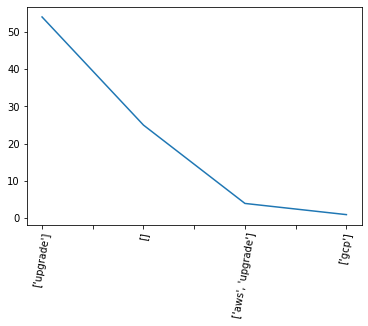

In [27]:
df["variant_type"].value_counts().plot()
plt.xticks(rotation=80)
plt.show()

In the above cell, we can see that the variant : aws and upgrade have been marked in the column variant_type.
This is how sippy looks up for some keywords that comprise of these variants and further catergorie the tests accordingly.

#### Curated TRT Tests

In [28]:
## curated test substrings
curated_test = [
    "[Feature:SCC][Early] should not have pod creation failures during install",
    "infrastructure should work",
    "install should work",
    "Kubernetes APIs remain available",
    "OAuth APIs remain available",
    "OpenShift APIs remain available",
    "Pod Container Status should never report success for a pending container",
    "pods should never transition back to pending",
    "pods should successfully create sandboxes",
    "upgrade should work",
    "Cluster completes upgrade",
]

In [29]:
df["Curated TRT"] = details["original-name"].apply(
    lambda x: [m for m in curated_test if m in x]
)
df["Curated TRT"] = df["Curated TRT"].map(str)

In [30]:
df["Curated TRT"].head()

0              ['OpenShift APIs remain available']
1                                               []
2                                               []
3    ['pods should successfully create sandboxes']
4    ['pods should successfully create sandboxes']
Name: Curated TRT, dtype: object

In [31]:
df["Curated TRT"].unique()

array(["['OpenShift APIs remain available']", '[]',
       "['pods should successfully create sandboxes']",
       "['pods should never transition back to pending']",
       "['Kubernetes APIs remain available']",
       "['OAuth APIs remain available']", "['Cluster completes upgrade']"],
      dtype=object)

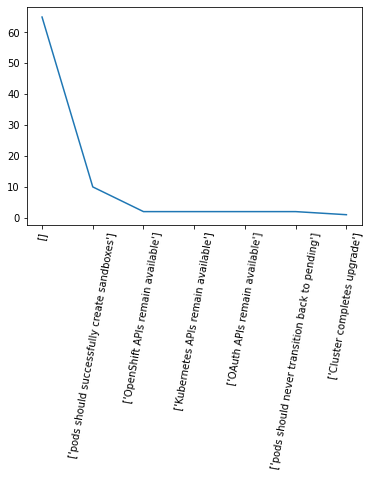

In [32]:
df["Curated TRT"].value_counts().plot()
plt.xticks(rotation=80)
plt.show()

In [33]:
## Custom Job Setup Containers
custom_job = [
    "e2e-aws-upgrade-ipi-install-install-stableinitial",
    "e2e-aws-upgrade-rollback-ipi-install-install-stableinitial",
    "e2e-aws-proxy-ipi-install-install",
    "e2e-aws-workers-rhel7-ipi-install-install",
    "e2e-azure-upgrade-ipi-conf-azure",
    "e2e-gcp-upgrade-ipi-install-install-stableinitial",
    "e2e-metal-ipi-baremetalds-devscripts-setup",
    "e2e-metal-ipi-ovn-ipv6-baremetalds-devscripts-setup",
    "e2e-metal-ipi-ovn-dualstack-baremetalds-devscripts-setup",
    "e2e-vsphere-ipi-install-vsphere",
    "e2e-vsphere-upi-upi-install-vsphere",
    "e2e-vsphere-upi-serial-upi-install-vsphere",
    "e2e-vsphere-serial-ipi-install-vsphere",
]

In [34]:
df["customJob"] = details["original-name"].apply(
    lambda x: [m for m in custom_job if m in x]
)
df["customJob"] = df["customJob"].map(str)
df.head()

,original-name,alert,linked_bugs,messages,short_texts,statuses,target,user_property,Type,Test Name,values,variant_type,Curated TRT,customJob
0,Cluster upgrade.[sig-api-machinery] OpenShift ...,NA,[],"[API ""openshift-api-available"" was unreachable...","[F, F, , , F, , , ]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",Cluster upgrade.[sig-api-machinery] OpenShift ...,NA,Cluster upgrade,[sig-api-machinery] OpenShift APIs remain avai...,"[12, 12, 0, 0, 1, 1, 0, 0, 12, 0, 0, 0, 0, 1, ...",['upgrade'],['OpenShift APIs remain available'],[]
1,Cluster upgrade.[sig-network-edge] Application...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[Service was unreachable during disruption for...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",Cluster upgrade.[sig-network-edge] Application...,NA,Cluster upgrade,[sig-network-edge] Application behind service ...,"[12, 12, 0, 0, 12, 12, 0, 0, 12, 0, 0, 0, 0, 1...",['upgrade'],[],[]
2,openshift-tests.[sig-arch] Monitor cluster whi...,"{'fail-cl': '1', 'fail-count': 8, 'fail-time':...",[],[99 error level events were detected during th...,"[F, F, F, F, F, F, F, F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-arch] Monitor cluster whi...,NA,openshift-tests,[sig-arch] Monitor cluster while tests execute,"[12, 12, 0, 0, 12, 12, 0, 0, 12, 0, 0, 0, 0, 1...",[],[],[]
3,openshift-tests.[sig-network] pods should succ...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[14 failures to create the sandbox\n\nns/opens...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-network] pods should succ...,NA,openshift-tests,[sig-network] pods should successfully create ...,"[12, 12, 0, 0, 12, 12, 0, 0, 12, 0, 0, 0, 0, 1...",[],['pods should successfully create sandboxes'],[]
4,openshift-tests.[sig-network] pods should succ...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[12 failures to create the sandbox\n\nns/opens...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-network] pods should succ...,NA,openshift-tests,[sig-network] pods should successfully create ...,"[12, 12, 0, 0, 12, 12, 0, 0, 12, 0, 0, 0, 0, 1...",[],['pods should successfully create sandboxes'],[]


In [35]:
# Valid Buzilla Components
ValidBugzillaComponents = [
    "apiserver-auth",
    "assisted-installer",
    "Bare Metal Hardware Provisioning",
    "Build",
    "Cloud Compute",
    "Cloud Credential Operator",
    "Cluster Loader",
    "Cluster Version Operator",
    "CNF Variant Validation",
    "Compliance Operator",
    "config-operator",
    "Console Kubevirt Plugin",
    "Console Metal3 Plugin",
    "Console Storage Plugin",
    "Containers",
    "crc",
    "Dev Console",
    "DNS",
    "Documentation",
    "Etcd",
    "Federation",
    "File Integrity Operator",
    "Fuse",
    "Hawkular",
    "ibm-roks-toolkit",
    "Image",
    "Image Registry",
    "Insights Operator",
    "Installer",
    "ISV Operators",
    "Jenkins",
    "kata-containers",
    "kube-apiserver",
    "kube-controller-manager",
    "kube-scheduler",
    "kube-storage-version-migrator",
    "Logging",
    "Machine Config Operator",
    "Management Console",
    "Metering Operator",
    "Migration Tooling",
    "Monitoring",
    "Multi-Arch",
    "Multi-cluster-management",
    "Networking",
    "Node",
    "Node Feature Discovery Operator",
    "Node Tuning Operator",
    "oauth-apiserver",
    "oauth-proxy",
    "oc",
    "OLM",
    "openshift-apiserver",
    "openshift-controller-manager",
    "Operator SDK",
    "Performance Addon Operator",
    "Reference Architecture",
    "Registry Console",
    "Release",
    "RHCOS",
    "RHMI Monitoring",
    "Routing",
    "Samples",
    "Security",
    "Service Broker",
    "Service Catalog",
    "service-ca",
    "Special Resources Operator",
    "Storage",
    "Templates",
    "Test Infrastructure",
    "Unknown",
    "Windows Containers",
]

In [36]:
df["Valid Bugzilla Components"] = details["original-name"].apply(
    lambda x: [m for m in ValidBugzillaComponents if m in x]
)
df["Valid Bugzilla Components"] = df["Valid Bugzilla Components"].map(str)

In [37]:
df

,original-name,alert,linked_bugs,messages,short_texts,statuses,target,user_property,Type,Test Name,values,variant_type,Curated TRT,customJob,Valid Bugzilla Components
0,Cluster upgrade.[sig-api-machinery] OpenShift ...,NA,[],"[API ""openshift-api-available"" was unreachable...","[F, F, , , F, , , ]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",Cluster upgrade.[sig-api-machinery] OpenShift ...,NA,Cluster upgrade,[sig-api-machinery] OpenShift APIs remain avai...,"[12, 12, 0, 0, 1, 1, 0, 0, 12, 0, 0, 0, 0, 1, ...",['upgrade'],['OpenShift APIs remain available'],[],[]
1,Cluster upgrade.[sig-network-edge] Application...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[Service was unreachable during disruption for...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",Cluster upgrade.[sig-network-edge] Application...,NA,Cluster upgrade,[sig-network-edge] Application behind service ...,"[12, 12, 0, 0, 12, 12, 0, 0, 12, 0, 0, 0, 0, 1...",['upgrade'],[],[],[]
2,openshift-tests.[sig-arch] Monitor cluster whi...,"{'fail-cl': '1', 'fail-count': 8, 'fail-time':...",[],[99 error level events were detected during th...,"[F, F, F, F, F, F, F, F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-arch] Monitor cluster whi...,NA,openshift-tests,[sig-arch] Monitor cluster while tests execute,"[12, 12, 0, 0, 12, 12, 0, 0, 12, 0, 0, 0, 0, 1...",[],[],[],[]
3,openshift-tests.[sig-network] pods should succ...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[14 failures to create the sandbox\n\nns/opens...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-network] pods should succ...,NA,openshift-tests,[sig-network] pods should successfully create ...,"[12, 12, 0, 0, 12, 12, 0, 0, 12, 0, 0, 0, 0, 1...",[],['pods should successfully create sandboxes'],[],[]
4,openshift-tests.[sig-network] pods should succ...,"{'fail-cl': '1', 'fail-count': 6, 'fail-time':...",[],[12 failures to create the sandbox\n\nns/opens...,"[F, F, F, F, F, F, , F]","[{'count': 2, 'value': 12}, {'count': 2, 'valu...",openshift-tests.[sig-network] pods should succ...,NA,openshift-tests,[sig-network] pods should successfully create ...,"[12, 12, 0, 0, 12, 12, 0, 0, 12, 0, 0, 0, 0, 1...",[],['pods should successfully create sandboxes'],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,openshift-tests.[sig-node] pods should never t...,NA,[],"[, , , , , , , ]","[, , , , , , , ]","[{'count': 2, 'value': 1}, {'count': 2, 'value...",openshift-tests.[sig-node] pods should never t...,NA,openshift-tests,[sig-node] pods should never transition back t...,"[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]",[],['pods should never transition back to pending'],[],[]
80,openshift-tests.[sig-node] pods should not fai...,NA,[],"[, , , , , , , ]","[, , , , , , , ]","[{'count': 2, 'value': 1}, {'count': 2, 'value...",openshift-tests.[sig-node] pods should not fai...,NA,openshift-tests,[sig-node] pods should not fail on systemd tim...,"[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]",[],[],[],[]
81,operator.All images are built and tagged into ...,NA,[],"[, , , , , , , , , , , , , , , ]","[, , , , , , , , , , , , , , , ]","[{'count': 16, 'value': 1}]",operator.All images are built and tagged into ...,NA,operator,All images are built and tagged into stable,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",[],[],[],[]
82,operator.Find all of the input images from ocp...,NA,[],"[, , , , , , , , , , , , , , , ]","[, , , , , , , , , , , , , , , ]","[{'count': 16, 'value': 1}]",operator.Find all of the input images from ocp...,NA,operator,Find all of the input images from ocp/4.5:${co...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",[],[],[],['oc']


In [38]:
df["Valid Bugzilla Components"].unique()

array(['[]', "['kube-apiserver']", "['openshift-apiserver']",
       "['config-operator']", "['kube-controller-manager']",
       "['kube-scheduler']", "['kube-storage-version-migrator']",
       "['openshift-controller-manager']", "['service-ca']",
       "['Node', 'oc']", "['oc']"], dtype=object)

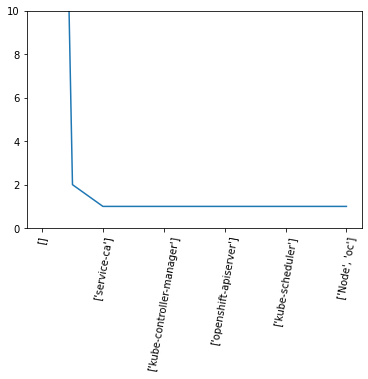

In [39]:
df["Valid Bugzilla Components"].value_counts().plot()
plt.xticks(rotation=80)
plt.ylim(0, 10)
plt.show()

In this notebook, we have seen a few categories like Curated Jobs, classifying the jobs based on Variants and Bugzilla Components that can be seen on Sippy Dashboard. We can also try out more dashboards to see better results. This notebook takes in account job: https://testgrid.k8s.io/redhat-openshift-ocp-release-4.6-informing/table?&show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.5-to-4.6 case. But we can change this link in cell[10] and see various different dashboards and perform this analysis sippy uses.